# Introduction to Deep Learning: Binary sentiment classification


In this project, we explore deep learning concepts in binary sentiment classification. The data set consists of movie reviews with the label "positive" and "negative" and it was compiled by Maas et al. http://ai.stanford.edu/~amaas/data/sentiment/.

The code is heavily based on the two following references:

- Code by Changhuixu in github: https://github.com/changhuixu/sentiment-analysis-using-python/ 
- Code by Usman Malik: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/.

## Index

[0. Installing packages and nice functions](#section0)

[1. Creating Data Set](#section1)
* [1.1 Creating data set](#section1.1)
* [1.2 Grabbing the data and building train and test sets](#section1.2)



[2. Naive Bayes approach](#section2)

* [2.1. Prior: Are people mean?](#section2.1)
* [2.2. Smoothing parameter: How do we deal with new words?](#section2.2)
* [2.3. Tf-dif: Is the word "movie" important in movie reviews?](#section2.2)

[3. Support Vector Machines ](#section3)
* [3.1. Type of kernel (linear, RBF, NuSVM)](#section3.1)

[4. CNN ](#section4)
* [4.1 Building data set and preprocessing](#section4.1)
* [4.2. Example from paper](#section4.2)
* [4.3. Number of batches](#section4.3)
* [4.4. Number of filters](#section4.4)
* [4.5. Size of kernels ](#section4.5)


[5. LSTM ](#section5)


[6. Comparisons](#section6)
* [6.1. Machine learning techniques](#section6.1)
* [6.2. Deep Learning techniques](#section6.2)
    * [6.2.1. Changing sentence length](#section6.2.1)
    * [6.2.2. Amount of training data ](#section6.2.2)
    * [6.2.3. Amount of time](#section6.2.3)
    
  
    

[7. Play around](#section7)

<a id='section0'></a>
## 0) Installing packages and nice functions
\textbf{Function to toggle/hide}  

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

\textbf{Import libraries}

In [2]:
dataset_path='/Deep Learning Project/aclImdb/'

import numpy
import pickle as pkl
import matplotlib.pyplot as plt


from collections import OrderedDict

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import glob
import os
import re

try:
    maketrans = ''.maketrans
except AttributeError:
    # fallback for Python 2
    from string import maketrans
    
    
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros



from numpy import array
from keras import regularizers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import six.moves.cPickle as pickle


from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score
import six.moves.cPickle as pickle
    
hide_toggle()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

[1. Creating Data Set](#section1)
* [1.1. Preprocessing](#section1.1)
* [1.2. Building train and test sets](#section1.2)




<a id='section1'></a>

## 1) Creating Data set
 
<a id='section1.1'></a>
\textbf{1.1 Preprocessing}


- Stopwords: From NLTK (natural language toolkit), list of commonly used words that we choose to ignore. 
    
- Trash characters: list of commonly used symbols that we choose to ignore.
    
- Non ASCII characters: replace them with space
    
- Break tags to new line

- Removes spaces  




In [22]:
def extract_words(sentences):
    result = []
    stop = stopwords.words('english')
    trash_characters = '?.,!:;"$%^&*()#@+/0123456789<>=\\[]_~{}|`'
    trans = maketrans(trash_characters, ' '*len(trash_characters))

    for text in sentences:
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = text.replace('<br />', ' ')
        text = text.replace('--', ' ').replace('\'s', '')
        text = text.translate(trans)
        text = ' '.join([w for w in text.split() if w not in stop])
        
        words = []
        for word in text.split():
            word = word.lstrip('-\'\"').rstrip('-\'\"')
            if len(word)>2 :
                words.append(word.lower())
        text = ' '.join(words)
        result.append(text.strip())
    return result

def extract_words2(sentences):
    result = []
    stop = stopwords.words('english')
    trash_characters = '?.,!:;"$%^&*()#@+/0123456789<>=\\[]_~{}|`'
    negationwords = ['can\'t','cannot','didn\'t','not', 'won\'t'];
    trans = maketrans(trash_characters, ' '*len(trash_characters))

    for text in sentences:
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = text.replace('<br />', ' ')
        text = text.replace('--', ' ').replace('\'s', '')
        text = text.translate(trans)
        text = ' '.join([w for w in text.split()])     # IRENE: Change for Next Word Negation
        
        words = []
        negate = False;
        for word in text.split():
            word = word.lstrip('-\'\"').rstrip('-\'\"')
            if negate == True:                         # IRENE: Change for Next Word Negation
                word = "not" + word;
                negate = False;
            if word in negationwords:
                negate = True;
                
            if len(word)>2 and word not in stop:        # IRENE: Change for Next Word Negation
                words.append(word.lower())
        
        
        text = ' '.join(words)
        result.append(text.strip())
    return result



hide_toggle()

The next two cells are to show case what goes on on the preprocessing. 

In [25]:
# IRENE: I wrote these two functions to figure out what was going on


def showExtract_words(Example):
    print(Example)
    result = []
    stop = stopwords.words('english')
    trash_characters = '?.,!:;"$%^&*()#@+/0123456789<>=\\[]_~{}|`'
    trans = maketrans(trash_characters, ' '*len(trash_characters))

    for text in Example:
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        print(text)
        text = text.replace('<br />', ' ')
        print(text)
        text = text.replace('--', ' ').replace('\'s', '')
        print(text)
        text = text.translate(trans)
        print(text)
        text = ' '.join([w for w in text.split() if w not in stop])

        words = []
        for word in text.split():
            word = word.lstrip('-\'\"').rstrip('-\'\"')
            if len(word)>2 :
                words.append(word.lower())
            print(word)
        text = ' '.join(words)
        print('****')
        print(text)
        
def showExtract_wordsNWN(Example):
    print(Example)
    result = []
    stop = stopwords.words('english')
    negationwords = ['can\'t','cannot','didn\'t','not', 'won\'t'];
    trash_characters = '?.,!:;"$%^&*()#@+/0123456789<>=\\[]_~{}|`'
    trans = maketrans(trash_characters, ' '*len(trash_characters))

    for text in Example:
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        print(text)
        text = text.replace('<br />', ' ')
        print(text)
        text = text.replace('--', ' ').replace('\'s', '')
        print(text)
        text = text.translate(trans)
        print(text)
        text = ' '.join([w for w in text.split()])

        words = []
        negate = False;
        for word in text.split():
            word = word.lstrip('-\'\"').rstrip('-\'\"')
            if negate == True:
                    word = "not" + word;

                    negate = False;
            if word in negationwords:
                    negate = True;
            if len(word)>2 and word not in stop:
                words.append(word.lower())
            print(word)
        text = ' '.join(words)
        print('****')
        print(text)

hide_toggle()

In [28]:
print('Example of how preprocessing works: original version: \n')
Example =['Today we are going to have fun in Deep Learning ∑?=?= class <br />, it´s sooò cool. Yes, I can\'t wait!'.strip()]

showExtract_words(Example)


print('Example of how preprocessing works: Next word negation: \n')
Example =['Today we are going to have fun in Deep Learning ∑?=?= class <br />, it´s sooò cool. Yes, I can\'t wait!'.strip()]

showExtract_wordsNWN(Example)

hide_toggle()

Example of how preprocessing works: original version: 

["Today we are going to have fun in Deep Learning ∑?=?= class <br />, it´s sooò cool. Yes, I can't wait!"]
Today we are going to have fun in Deep Learning  ?=?= class <br />, it s soo  cool. Yes, I can't wait!
Today we are going to have fun in Deep Learning  ?=?= class  , it s soo  cool. Yes, I can't wait!
Today we are going to have fun in Deep Learning  ?=?= class  , it s soo  cool. Yes, I can't wait!
Today we are going to have fun in Deep Learning       class    it s soo  cool  Yes  I can't wait 
Today
going
fun
Deep
Learning
class
soo
cool
Yes
I
can't
wait
****
today going fun deep learning class soo cool yes can't wait
Example of how preprocessing works: Next word negation: 

["Today we are going to have fun in Deep Learning ∑?=?= class <br />, it´s sooò cool. Yes, I can't wait!"]
Today we are going to have fun in Deep Learning  ?=?= class <br />, it s soo  cool. Yes, I can't wait!
Today we are going to have fun in Deep Learni

<a id='section1.2'></a>
\textbf{1.2 Grabbing the data and building train and test sets}

- Label y is 1 is the review is positive and 0 if it's negative.
- For this part of the talk, the test size is 20% and the training set an 80% (modified from original code)
- Characteristics: 50000 reviews in total, half of them positive and half of them negative


In [31]:
def grab_data(path):
    sentences = []
    currdir = os.getcwd()
    os.chdir(path)
    for ff in glob.glob("*.txt"):
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    os.chdir(currdir)
    sentences = extract_words2(sentences)

    return sentences



def main():
    # Get the dataset from http://ai.stanford.edu/~amaas/data/sentiment/
    path = dataset_path

    train_x_pos = grab_data(path+'train/pos')
    train_x_neg = grab_data(path+'train/neg')
    train_x = train_x_pos + train_x_neg
    train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

    test_x_pos = grab_data(path+'test/pos')
    test_x_neg = grab_data(path+'test/neg')
    test_x = test_x_pos + test_x_neg
    test_y = [1] * len(test_x_pos) + [0] * len(test_x_neg)
    
    y = test_y + train_y;
    X = test_x + train_x
    X = X[0:40000]       #Irene: so that comparison with NN is fair
    y = y[0:40000]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)
    
    f = open('train.pkl', 'wb')
    pkl.dump((train_x, train_y), f, -1)
    f.close()
    f = open('test.pkl', 'wb')
    pkl.dump((test_x, test_y), f, -1)
    f.close()


if __name__ == '__main__':
    main()

hide_toggle()

<a id='section2'></a>
## 2) Naive Bayesian approach

https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

We use a naive Bayes classifier, which is suitable for classification with discrete features. 

\textbf{Super strong assumption not justified at all:} each word is independent of each other, so 

$$p(y|x_1, \ldots, x_n) = \dfrac{p(y)\prod_{i}^{n}p(x_i|y)}{p(x_1, \ldots, x_n)}$$




We explore several options:



- Priors 
- Smoothing parameter
- Tf-idf

Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [32]:
# Load All Reviews in train and test datasets
f = open('train.pkl', 'rb')
reviews = pickle.load(f)
f.close()

f = open('test.pkl', 'rb')
test = pickle.load(f)
f.close()



hide_toggle()

In [34]:
print('Original code results + NWN:')

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in reviews[0]])
test_features = vectorizer.transform([r for r in test[0]])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB()
nb.fit(train_features, [int(r) for r in reviews[1]])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(test[1], predictions))
print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))


hide_toggle()

Original code results + NWN:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2986
           1       0.91      0.88      0.90      5014

    accuracy                           0.87      8000
   macro avg       0.86      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000

accuracy: 0.87275


<a id='section2.1'></a>
## 2.1 Are people mean? 

Previously, the method is automatically learning the prior distribution probability. Since we have a "symmetric data set", 12500 examples of each of the classes, it will probably learn that the probability distribution is uniform. 

In this subsection, we fit the model taking into account a prior distribution $p(y=0) = r$ and $p(y=1) = 1-r$. My wish was to see that a prior distribution with a bigger negative probability would work better: people are mean and sarcastic and what the network thought is a innocent positive word, it's actually negative. 

I was proved wrong with this data set: apparently people are nicer than you'd expect!


In [35]:
#print('Are people mean??')

i = 0;
accuracy = [0.0 for j in range(20)];
for r in np.linspace(0, 1, 20):
    #print('Prior distribution set to')
    #print([r, 1-r])
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
    vectorizer = CountVectorizer()
    train_features = vectorizer.fit_transform([r for r in reviews[0]])
    test_features = vectorizer.transform([r for r in test[0]])

    # Fit a naive bayes model to the training data.
    # This will train the model using the word counts we computer, 
    #       and the existing classifications in the training set.
    nb = MultinomialNB(fit_prior = True, class_prior = [r, 1-r])
    nb.fit(train_features, [int(r) for r in reviews[1]])

    # Now we can use the model to predict classifications for our test features.
    predictions = nb.predict(test_features)

    # Compute the error.  
    #print(metrics.classification_report(test[1], predictions))
    #print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
    accuracy[i]= metrics.accuracy_score(test[1], predictions);
    i =i+1;

hide_toggle()

/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)


So, are people mean? Maximum is in
0.05263157894736842


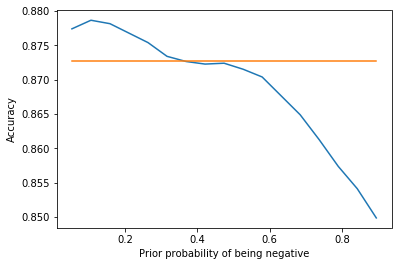

In [37]:
print('So, are people mean? Maximum is in')


print(np.linspace(0, 1, 20)[1])

prob = np.linspace(0, 1, 20)[1:18];
plt.plot(prob, accuracy[1:18])
plt.plot(prob, len(prob)*[0.87275])
plt.xlabel('Prior probability of being negative')
plt.ylabel('Accuracy')

hide_toggle()

<a id='section2.2'></a>
## 2.2 How do we treat new words? 

from https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf

Given a review formed by $d$ words $x = (x_1, \ldots, x_d)$, the estimator for the conditioned probability is 
$$\hat \theta_{y,i} = \dfrac{N_{y,i}+\alpha}{N_{y} + d\alpha}$$


For big $\alpha$, assumes that every word is uniformly distributed. For $\alpha = 0$, you would have that a word that the training set has not seen will be given probability 0. By default, $\alpha = 1$



In [38]:
#print('How do we treat new words?')

i = 0;
accuracyAlpha = [0.0 for j in range(20)];
for r in np.linspace(0, 5, 15):
    print(i)
    
    # Generate counts from text using a vectorizer.  
    # There are other vectorizers available, and lots of options you can set.
    # This performs our step of computing word counts.
    vectorizer = CountVectorizer()
    train_features = vectorizer.fit_transform([r for r in reviews[0]])
    test_features = vectorizer.transform([r for r in test[0]])

    # Fit a naive bayes model to the training data.
    # This will train the model using the word counts we computer, 
    #       and the existing classifications in the training set.
    nb = MultinomialNB(alpha = r)
    nb.fit(train_features, [int(r) for r in reviews[1]])

    # Now we can use the model to predict classifications for our test features.
    predictions = nb.predict(test_features)

    # Compute the error.  
    #print(metrics.classification_report(test[1], predictions))
    #print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
    accuracyAlpha[i]= metrics.accuracy_score(test[1], predictions);
    i =i+1;

hide_toggle()

0


/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


1
2
3
4
5
6
7
8
9
10
11
12
13
14


So, how do we treat new words, what would it be best?


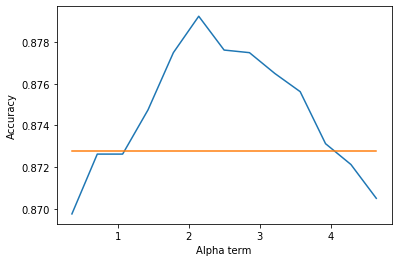

In [41]:
print('So, how do we treat new words, what would it be best?')

prob = np.linspace(0, 5, 15)[1:14];
plt.plot(prob, accuracyAlpha[1:14])
plt.plot(prob, len(prob)*[0.87275])
plt.xlabel('Alpha term')
plt.ylabel('Accuracy')

hide_toggle()

So, how do we treat new words, what would it be best?
0
1
2
3
4
5
6
7
8
9


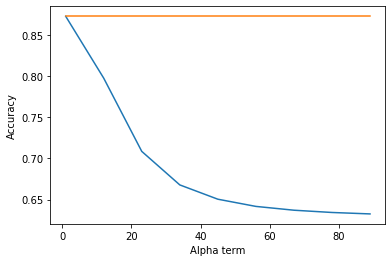

In [44]:
print('So, how do we treat new words, what would it be best?')

#print('How do we treat new words?')

i = 0;
accuracyAlpha2 = [0.0 for j in range(10)];
for r in np.linspace(1, 100, 10):
    print(i)
    
    # Generate counts from text using a vectorizer.  
    # There are other vectorizers available, and lots of options you can set.
    # This performs our step of computing word counts.
    vectorizer = CountVectorizer()
    train_features = vectorizer.fit_transform([r for r in reviews[0]])
    test_features = vectorizer.transform([r for r in test[0]])

    # Fit a naive bayes model to the training data.
    # This will train the model using the word counts we computer, 
    #       and the existing classifications in the training set.
    nb = MultinomialNB(alpha = r)
    nb.fit(train_features, [int(r) for r in reviews[1]])

    # Now we can use the model to predict classifications for our test features.
    predictions = nb.predict(test_features)

    # Compute the error.  
    #print(metrics.classification_report(test[1], predictions))
    #print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
    accuracyAlpha2[i]= metrics.accuracy_score(test[1], predictions);
    i =i+1;

hide_toggle()


prob = np.linspace(1, 100, 10)[0:9];
plt.plot(prob, accuracyAlpha2[0:9])
plt.plot(prob, len(prob)*[0.87275])
plt.xlabel('Alpha term')
plt.ylabel('Accuracy')

hide_toggle()

<a id='section2.3'></a>
## 2.3 Can we improve this method? Is the word movie important?

Applying TFIDF, term frequency–inverse document frequency transformation, used to reflect how important a word is in a review. Naming $f$ the frequency of a word in a review, $N_{rev}$ the total number of reviews and $N_{rev,f}$ the total number of reviews that have that word, the transformation goes as: 


\begin{equation}
TF-IDF(word)= f\cdot\left(log\left(\dfrac{N_{rev}}{N_{rev,f}}\right)+1\right)
\end{equation}



https://www.cs.waikato.ac.nz/ml/publications/2004/kibriya_et_al_cr.pdf



In [46]:
print('Using tfidf: SAME RESULT')
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in reviews[0]])
test_features = vectorizer.transform([r for r in test[0]])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB()
nb.fit(train_features, [int(r) for r in reviews[1]])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(test[1], predictions))
print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
   

hide_toggle()

Using tfidf: SAME RESULT
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2986
           1       0.91      0.88      0.90      5014

    accuracy                           0.87      8000
   macro avg       0.86      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000

accuracy: 0.87275


In [47]:
print('Optimal methods together')


vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in reviews[0]])
test_features = vectorizer.transform([r for r in test[0]])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB(fit_prior = True, class_prior = [0.0526, 1-0.0526], alpha = 2)
nb.fit(train_features, [int(r) for r in reviews[1]])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(test[1], predictions))
print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
   

hide_toggle()

Optimal methods together??
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2986
           1       0.87      0.94      0.90      5014

    accuracy                           0.88      8000
   macro avg       0.88      0.85      0.86      8000
weighted avg       0.88      0.88      0.87      8000

accuracy: 0.8755


<a id='section3'></a>
## 3) SVM

- Support vector machines try to find the best hyperplane that separates classes. 

- We can transform our data using the kernel trick

- We see which methof works best for us



In [48]:
print("Using linear SVM")
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format(accuracy_score(test[1], prediction_liblinear)))



Using linear SVM
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2986
           1       0.91      0.94      0.93      5014

    accuracy                           0.90      8000
   macro avg       0.90      0.89      0.90      8000
weighted avg       0.90      0.90      0.90      8000

accuracy: 0.904875


In [49]:
print("Using RBF")
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Perform classification with SVM, kernel=RBF
classifier_liblinear = svm.SVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format( accuracy_score(test[1], prediction_liblinear)))



Using RBF


/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2986
           1       0.63      1.00      0.77      5014

    accuracy                           0.63      8000
   macro avg       0.31      0.50      0.39      8000
weighted avg       0.39      0.63      0.48      8000

accuracy: 0.62675


/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
print("Using NuSVC")
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Perform classification with SVM, kernel=RBF
classifier_liblinear = svm.NuSVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format( accuracy_score(test[1], prediction_liblinear)))




Using NuSVC


/Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.89      0.80      0.84      2986
           1       0.89      0.94      0.91      5014

    accuracy                           0.89      8000
   macro avg       0.89      0.87      0.88      8000
weighted avg       0.89      0.89      0.89      8000

accuracy: 0.88775


<a id='section4'></a>
## 4) CNN

<a id='section4.1'></a>
### 4.1 Building data set and preprocessing

In this case we don't do the trick of next word negation. We train with 32000, validate with 80000 and test with 10000 data points. 

Build data sets


In [53]:
def extract_words(sentences):
    result = []
    stop = stopwords.words('english')
    trash_characters = '?.,!:;"$%^&*()#@+/0123456789<>=\\[]_~{}|`'
    trans = maketrans(trash_characters, ' '*len(trash_characters))

    for text in sentences:
        text = re.sub(r'[^\x00-\x7F]+',' ', text)
        text = text.replace('<br />', ' ')
        text = text.replace('--', ' ').replace('\'s', '')
        text = text.translate(trans)
        text = ' '.join([w for w in text.split() if w not in stop])
        
        words = []
        for word in text.split():
            word = word.lstrip('-\'\"').rstrip('-\'\"')
            if len(word)>2 :
                words.append(word.lower())
        text = ' '.join(words)
        result.append(text.strip())
    return result




def grab_data(path):
    sentences = []
    currdir = os.getcwd()
    os.chdir(path)
    for ff in glob.glob("*.txt"):
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    os.chdir(currdir)
    sentences = extract_words(sentences)

    return sentences



def main():
    # Get the dataset from http://ai.stanford.edu/~amaas/data/sentiment/
    path = dataset_path

    train_x_pos = grab_data(path+'train/pos')
    
    train_x_neg = grab_data(path+'train/neg')
    
    train_x = train_x_pos + train_x_neg
    train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

    test_x_pos = grab_data(path+'test/pos')
    
    test_x_neg = grab_data(path+'test/neg')
   
    test_x = test_x_pos + test_x_neg
    test_y = [1] * len(test_x_pos) + [0] * len(test_x_neg)
    
    y = test_y + train_y;
    X = test_x + train_x
    
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)
    
    f = open('train.pkl', 'wb')
    pkl.dump((train_x, train_y), f, -1)
    f.close()
    f = open('test.pkl', 'wb')
    pkl.dump((test_x, test_y), f, -1)
    f.close()


if __name__ == '__main__':
    main()
    
# Load All Reviews in train and test datasets
f = open('train.pkl', 'rb')
reviews = pickle.load(f)
f.close()

f = open('test.pkl', 'rb')
test = pickle.load(f)
f.close()



hide_toggle()

Import Glove embbeding as seed for embedding from https://nlp.stanford.edu/projects/glove/




In [56]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

hide_toggle()

Transform text to vectors, and pad them so they all have the same length. 

In [57]:
# Generate vector from text using a vectorizer.  
# This performs a one-hot encoding


tokenizer = Tokenizer(num_words=90000)
tokenizer.fit_on_texts(reviews[0])

train_features = tokenizer.texts_to_sequences(reviews[0])
test_features = tokenizer.texts_to_sequences(test[0])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 300

train_features= pad_sequences(train_features, padding='post', maxlen=maxlen)
test_features = pad_sequences(test_features, padding='post', maxlen=maxlen)

hide_toggle()

Create embedding matrix for our dataset. 

In [58]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
hide_toggle()



Results of original code


W1206 02:44:09.993466 140735999492992 deprecation.py:323] From /Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          9118800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,183,057
Trainable params: 64,257
Non-trainable params: 9,118,800
_________________________________________________________________
None


W1206 02:44:10.463089 140735999492992 deprecation_wrapper.py:119] From /Users/irenemelgarejolermas/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 46s 1ms/step - loss: 0.4748 - acc: 0.7713 - val_loss: 0.4020 - val_acc: 0.8192
Epoch 2/6
32000/32000 [==============================] - 46s 1ms/step - loss: 0.3232 - acc: 0.8655 - val_loss: 0.3387 - val_acc: 0.8543
Epoch 3/6
32000/32000 [==============================] - 43s 1ms/step - loss: 0.2678 - acc: 0.8942 - val_loss: 0.3241 - val_acc: 0.8605
Epoch 4/6
32000/32000 [==============================] - 42s 1ms/step - loss: 0.2233 - acc: 0.9179 - val_loss: 0.3198 - val_acc: 0.8631
Epoch 5/6
32000/32000 [==============================] - 44s 1ms/step - loss: 0.1862 - acc: 0.9368 - val_loss: 0.3203 - val_acc: 0.8631
Epoch 6/6
10000/10000 [==============================] - 8s 774us/step
Test Score: 0.33926151764392853
Test Accuracy: 0.85589998960495


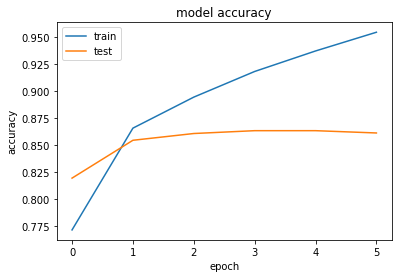

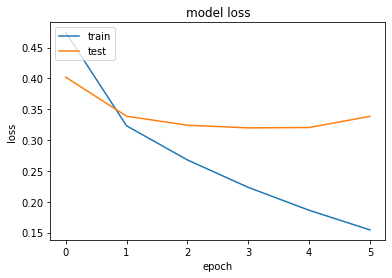

In [59]:
print('Results of original code')

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(train_features, reviews[1], batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()
hide_toggle()

<a id='section4.2'></a>
### 4.2 Using example from paper


Basing us in the structure proposed in "Sentiment Classification Using Convolutional Neural Networks":


In [70]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

tokenizer = Tokenizer(num_words=90000)
tokenizer.fit_on_texts(reviews[0])

train_features = tokenizer.texts_to_sequences(reviews[0])
test_features = tokenizer.texts_to_sequences(test[0])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 600

train_features= pad_sequences(train_features, padding='post', maxlen=maxlen)
test_features = pad_sequences(test_features, padding='post', maxlen=maxlen)

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
hide_toggle()






Using similar parameter to those from the paper: 
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch

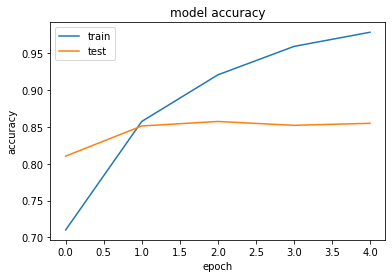

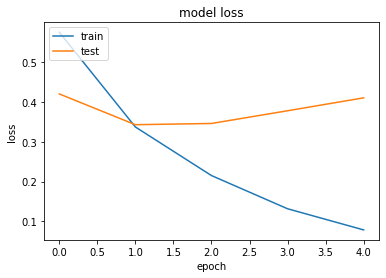

In [75]:
print("Using similar parameter to those from the paper: ")


model = Sequential()

embedding_layer = Embedding(vocab_size, 25, input_length=maxlen, trainable=True) #IRENE Same parameters than in paper
model.add(embedding_layer)

model.add(Conv1D(16, 3, activation='relu')) #IRENE Same parameters than in paper
model.add(Conv1D(8, 3, activation='relu'))  #IRENE Same parameters than in paper
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))) #IRENE:sigmoid because binary,regulatization
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()
    
hide_toggle()

<a id='section4.3'></a>

## 4.3 Changing the batch size

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

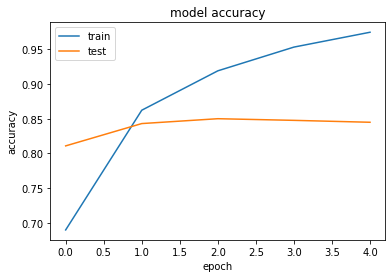

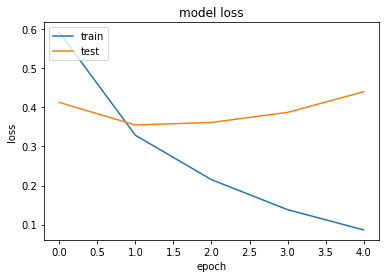

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 8)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

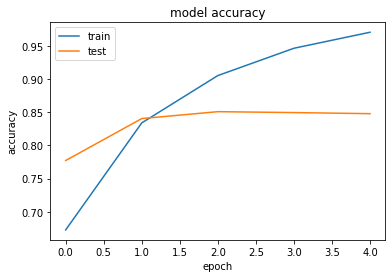

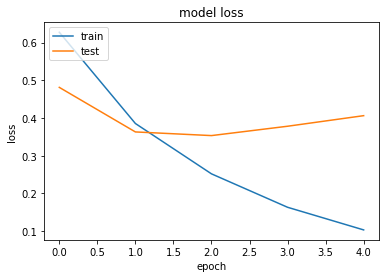

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

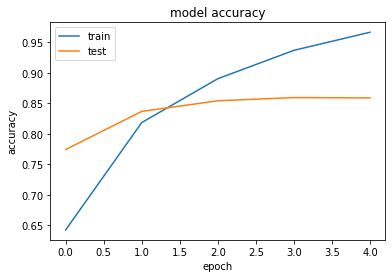

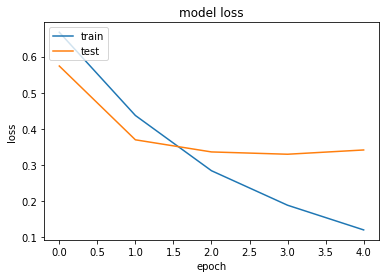

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

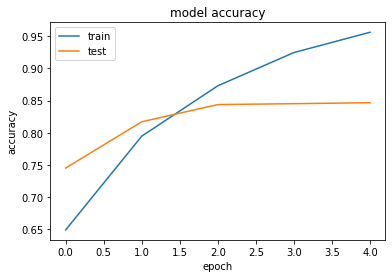

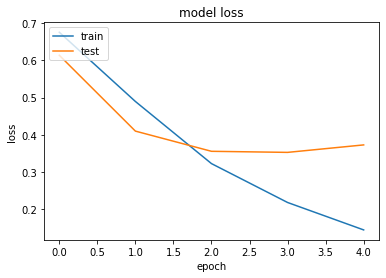

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_23 (Glo (None, 8)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

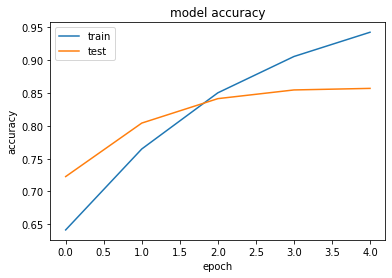

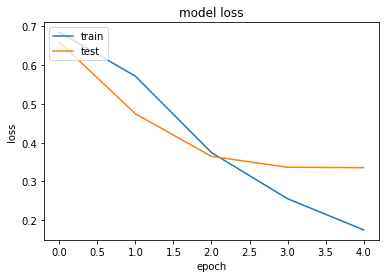

In [81]:
BatchAccuracy = [0 for x in range(5)];
i = 0;
for r in np.linspace(128, 512, 5):
    r = int(r)

    model = Sequential()

    embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
    model.add(embedding_layer)

    model.add(Conv1D(16, 3, activation='relu'))
    model.add(Conv1D(8, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    history = model.fit(train_features, reviews[1], batch_size=r, epochs=5, verbose=1, validation_split=0.2)

    score = model.evaluate(test_features, test[1], verbose=1)
    
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    BatchAccuracy[i] = score[1];
    i =i+1;
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    
hide_toggle()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 8)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

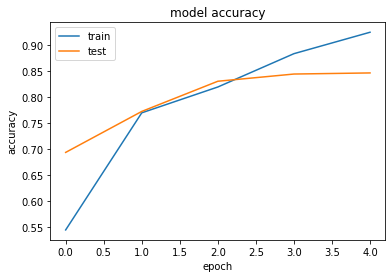

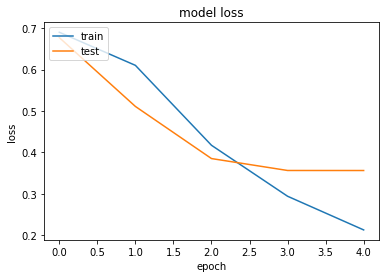

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

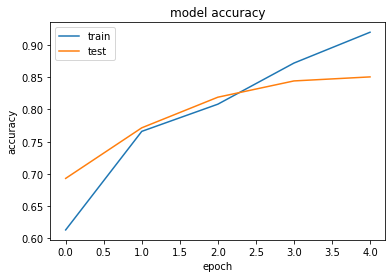

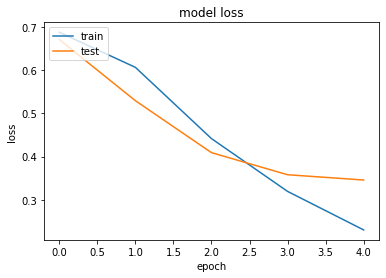

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 8)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

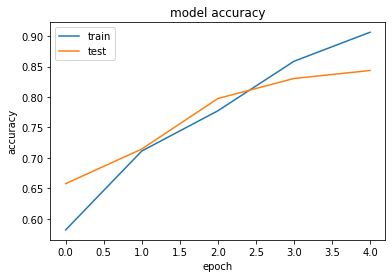

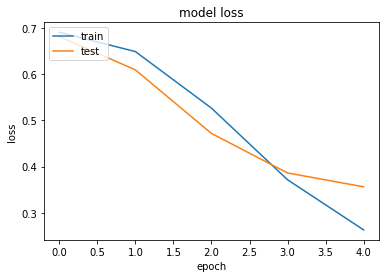

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_28 (Glo (None, 8)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

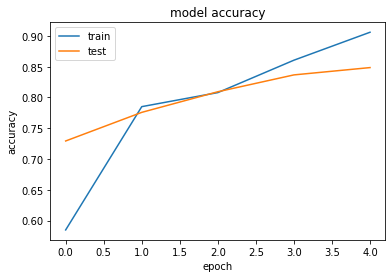

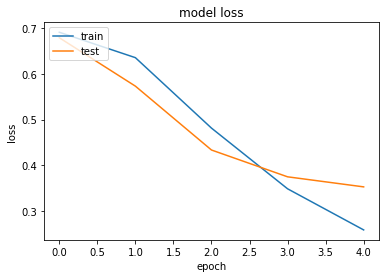

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

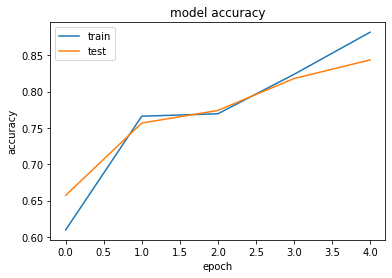

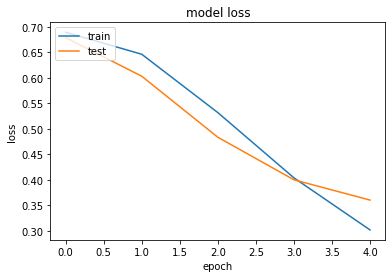

In [84]:
BatchAccuracy2 = [0 for x in range(5)];
i = 0;
for r in np.linspace(600, 1000, 5):
    r = int(r)

    model = Sequential()

    embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
    model.add(embedding_layer)

    model.add(Conv1D(16, 3, activation='relu'))
    model.add(Conv1D(8, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    history = model.fit(train_features, reviews[1], batch_size=r, epochs=5, verbose=1, validation_split=0.2)

    score = model.evaluate(test_features, test[1], verbose=1)
    
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    BatchAccuracy2[i] = score[1];
    i =i+1;
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    
hide_toggle()

Text(0, 0.5, 'Accuracy')

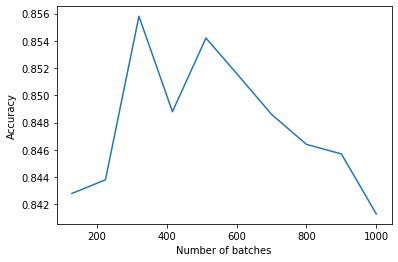

In [86]:
batches = np.concatenate((np.linspace(128, 512, 5), np.linspace(600, 1000, 5)))
Acc = np.concatenate((BatchAccuracy, BatchAccuracy2))


plt.plot(batches, Acc)
plt.xlabel("Number of batches")
plt.ylabel("Accuracy")

<a id='section4.4'></a>
## 4.4 Changing the number of filters

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 598, 36)           2736      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 596, 18)           1962      
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 18)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 19        
Total params: 2,284,417
Trainable params: 2,284,417
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

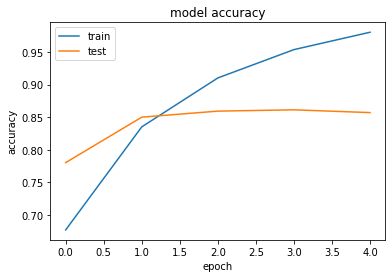

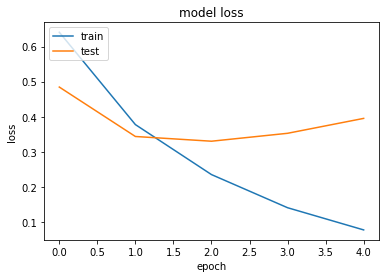

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 598, 58)           4408      
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 596, 29)           5075      
_________________________________________________________________
global_max_pooling1d_32 (Glo (None, 29)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 30        
Total params: 2,289,213
Trainable params: 2,289,213
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

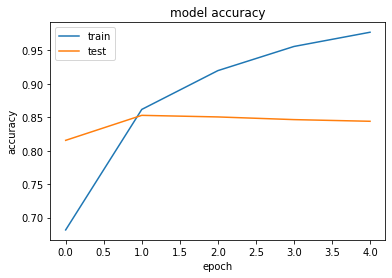

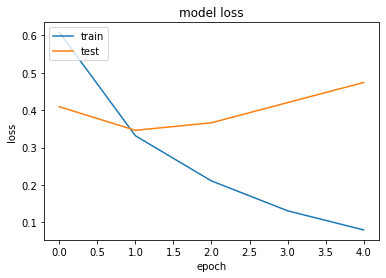

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 598, 82)           6232      
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 596, 41)           10127     
_________________________________________________________________
global_max_pooling1d_33 (Glo (None, 41)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 42        
Total params: 2,296,101
Trainable params: 2,296,101
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

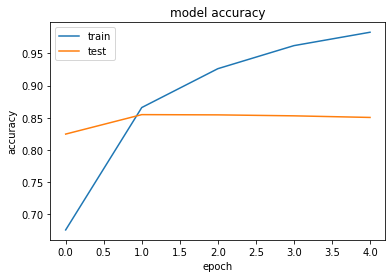

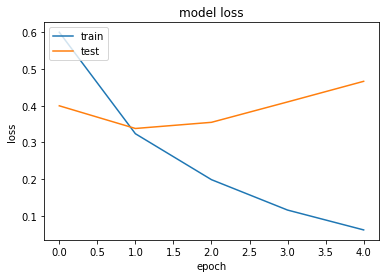

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 598, 106)          8056      
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 596, 53)           16907     
_________________________________________________________________
global_max_pooling1d_34 (Glo (None, 53)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 54        
Total params: 2,304,717
Trainable params: 2,304,717
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

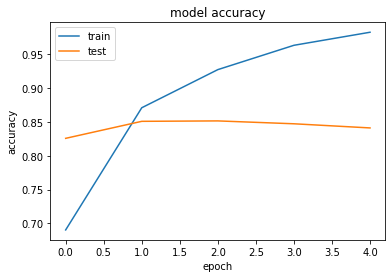

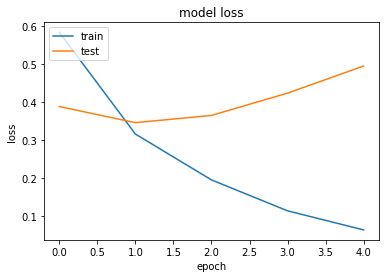

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 598, 128)          9728      
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 596, 64)           24640     
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 2,314,133
Trainable params: 2,314,133
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
 1280/32000 [>.............................] 

KeyboardInterrupt: 

In [89]:
Filters = [0 for x in range(8)];
i = 0;
for r in np.linspace(18, 100, 8):
    r = int(r)

    model = Sequential()

    embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
    model.add(embedding_layer)

    model.add(Conv1D(2*r, 3, activation='relu'))
    model.add(Conv1D(r, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    history = model.fit(train_features, reviews[1], batch_size=320, epochs=5, verbose=1, validation_split=0.2)

    score = model.evaluate(test_features, test[1], verbose=1)
    
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    Filters[i] = score[1];
    i =i+1;
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    
hide_toggle()

Text(0, 0.5, 'Accuracy')

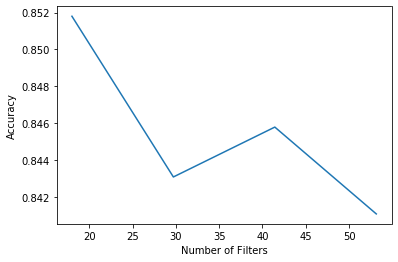

In [95]:
plt.plot(np.linspace(18, 100, 8)[0:4],Filters[0:4])
plt.xlabel("Number of Filters")
plt.ylabel("Accuracy")

<a id='section4.5'></a>
## 4.5 Changing size of the kernel

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 597, 16)           1616      
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 594, 8)            520       
_________________________________________________________________
global_max_pooling1d_37 (Glo (None, 8)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 9         
Total params: 2,281,845
Trainable params: 2,281,845
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

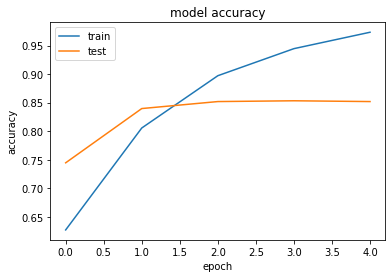

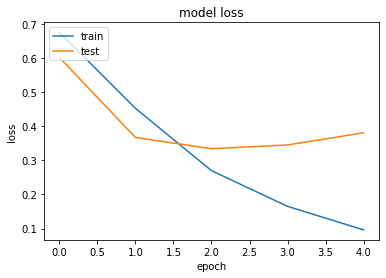

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 596, 16)           2016      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 592, 8)            648       
_________________________________________________________________
global_max_pooling1d_38 (Glo (None, 8)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 2,282,373
Trainable params: 2,282,373
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

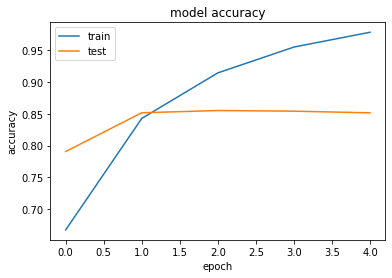

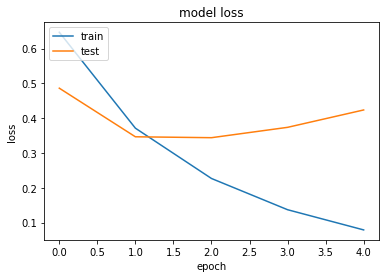

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 595, 16)           2416      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 590, 8)            776       
_________________________________________________________________
global_max_pooling1d_39 (Glo (None, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 9         
Total params: 2,282,901
Trainable params: 2,282,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

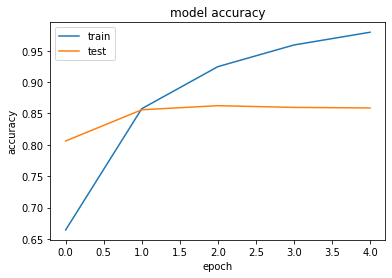

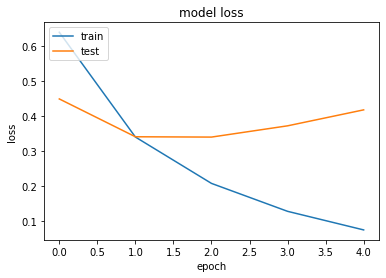

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 593, 16)           3216      
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 586, 8)            1032      
_________________________________________________________________
global_max_pooling1d_40 (Glo (None, 8)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 2,283,957
Trainable params: 2,283,957
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] 

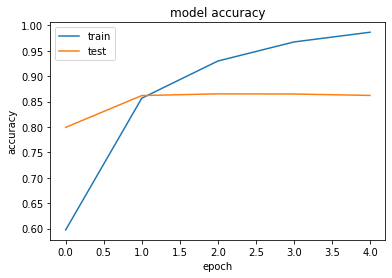

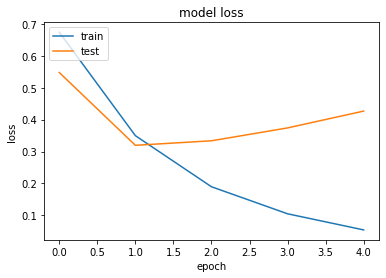

In [97]:
KernelAccuracy = [0 for x in range(5)];
i = 0;
for r in np.linspace(4, 8, 4):
    r = int(r)

    model = Sequential()

    embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
    model.add(embedding_layer)

    model.add(Conv1D(16, r, activation='relu'))
    model.add(Conv1D(8, r, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    history = model.fit(train_features, reviews[1], batch_size=320, epochs=5, verbose=1, validation_split=0.2)

    score = model.evaluate(test_features, test[1], verbose=1)
    
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    KernelAccuracy[i] = score[1];
    i =i+1;
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    
hide_toggle()

Text(0, 0.5, 'Accuracy')

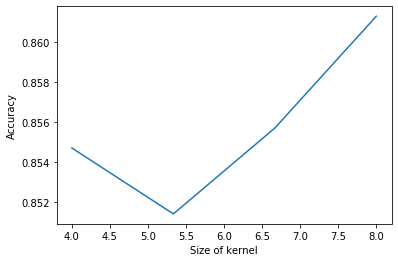

In [99]:
plt.plot(np.linspace(4, 8, 4), KernelAccuracy[0:4])
plt.xlabel("Size of kernel")
plt.ylabel("Accuracy")

Best method?
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 600, 25)           2279700   
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 598, 16)           1216      
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 596, 8)            392       
_________________________________________________________________
global_max_pooling1d_42 (Glo (None, 8)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 2,281,317
Trainable params: 2,281,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [===================

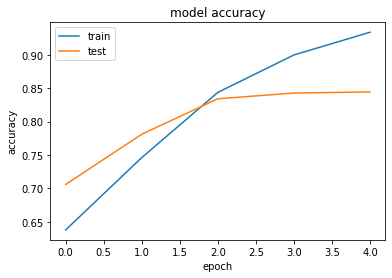

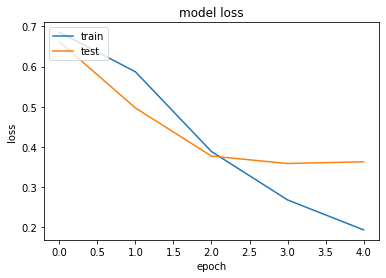

In [101]:
print('Best method?')

model = Sequential()

embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(8, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=600, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

<a id='section5'></a>
## 5) LSTM: Long Short Term Memory network



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          9118800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,236,177
Trainable params: 117,377
Non-trainable params: 9,118,800
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 219s 7ms/step - loss: 0.6884 - acc: 0.5229 - val_loss: 0.6921 - val_acc: 0.5055
Epoch 2/6
32000/32000 [==============================] - 212s 7ms/step - loss: 0.6930 - acc: 0.5048 - val_loss: 0.6932 - val_acc: 0.5052
Epoch 3/6
32000/32000 [=================

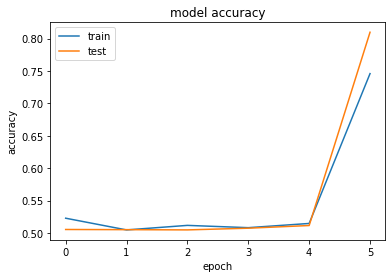

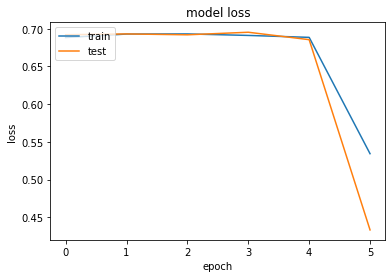

In [12]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()






<a id='section6'></a>
## 6) Comparison of best networks

<a id='section6.1'></a>
### 6.1 Machine Learning techniques


In [131]:
def grab_data(path):
    sentences = []
    currdir = os.getcwd()
    os.chdir(path)
    for ff in glob.glob("*.txt"):
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    os.chdir(currdir)
    sentences = extract_words2(sentences)

    return sentences



def main():
    # Get the dataset from http://ai.stanford.edu/~amaas/data/sentiment/
    path = dataset_path

    train_x_pos = grab_data(path+'train/pos')
    train_x_neg = grab_data(path+'train/neg')
    train_x = train_x_pos + train_x_neg
    train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

    test_x_pos = grab_data(path+'test/pos')
    test_x_neg = grab_data(path+'test/neg')
    test_x = test_x_pos + test_x_neg
    test_y = [1] * len(test_x_pos) + [0] * len(test_x_neg)
    
    y = test_y + train_y;
    X = test_x + train_x
    X = X[0:40000]       #Irene: so that comparison with NN is fair
    y = y[0:40000]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)
    
    f = open('train.pkl', 'wb')
    pkl.dump((train_x, train_y), f, -1)
    f.close()
    f = open('test.pkl', 'wb')
    pkl.dump((test_x, test_y), f, -1)
    f.close()


if __name__ == '__main__':
    main()

hide_toggle()

In [132]:
f = open('train.pkl', 'rb')
reviews = pickle.load(f)
f.close()

f = open('test.pkl', 'rb')
test = pickle.load(f)
f.close()


In [144]:
ShortRev = [x[-200:32500] for x in reviews[0]];
ShortTest = [x[-200:32500] for x in test[0]];
LittleTraining= reviews[0][0:5000]
LittleTest= reviews[0][1:1000]

LittleTrainingy= reviews[1][0:5000]
LittleTesty= reviews[1][1:1000]



import time


In [138]:
print('Best Bayes- Normal, time?')

start_time = time.time()



vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(ShortRev)
test_features = vectorizer.transform(ShortTest)

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in ShortRev])
test_features = vectorizer.transform([r for r in ShortTest])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB(fit_prior = True, class_prior = [0.0526, 1-0.0526], alpha = 2)
nb.fit(train_features, [int(r) for r in reviews[1]])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(test[1], predictions))
print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
   
print("--- %s seconds ---" % (time.time() - start_time))
hide_toggle()

Best Bayes- Normal, time?
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      2986
           1       0.76      0.98      0.86      5014

    accuracy                           0.80      8000
   macro avg       0.85      0.73      0.75      8000
weighted avg       0.83      0.80      0.78      8000

accuracy: 0.795375
--- 3.05745792388916 seconds ---


In [134]:
print('Best Bayes- SHORT TEXTS')


vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(ShortRev)
test_features = vectorizer.transform(ShortTest)

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in ShortRev])
test_features = vectorizer.transform([r for r in ShortTest])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB(fit_prior = True, class_prior = [0.0526, 1-0.0526], alpha = 2)
nb.fit(train_features, [int(r) for r in reviews[1]])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(test[1], predictions))
print("accuracy: {0}".format(metrics.accuracy_score(test[1], predictions)))
   

hide_toggle()

Best Bayes- SHORT TEXTS
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      2986
           1       0.76      0.98      0.86      5014

    accuracy                           0.80      8000
   macro avg       0.85      0.73      0.75      8000
weighted avg       0.83      0.80      0.78      8000

accuracy: 0.795375


In [146]:
print('Best Bayes- LITTLE TRAINING')


vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(ShortRev)
test_features = vectorizer.transform(ShortTest)

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([r for r in LittleTraining])
test_features = vectorizer.transform([r for r in LittleTest])

# Fit a naive bayes model to the training data.
# This will train the model using the word counts we computer, 
#       and the existing classifications in the training set.
nb = MultinomialNB(fit_prior = True, class_prior = [0.0526, 1-0.0526], alpha = 2)
nb.fit(train_features, [int(r) for r in LittleTrainingy])

# Now we can use the model to predict classifications for our test features.
predictions = nb.predict(test_features)

# Compute the error.  
print(metrics.classification_report(LittleTesty, predictions))
print("accuracy: {0}".format(metrics.accuracy_score(LittleTesty, predictions)))
   

hide_toggle()

Best Bayes- LITTLE TRAINING
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       360
           1       0.94      0.99      0.96       639

    accuracy                           0.95       999
   macro avg       0.96      0.94      0.95       999
weighted avg       0.95      0.95      0.95       999

accuracy: 0.950950950950951


In [139]:
print('Best SVM- Normal, time?')

start_time = time.time()

# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format(accuracy_score(test[1], prediction_liblinear)))


print("--- %s seconds ---" % (time.time() - start_time))
hide_toggle()


Best SVM- Normal, time?
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2986
           1       0.91      0.94      0.93      5014

    accuracy                           0.90      8000
   macro avg       0.90      0.89      0.90      8000
weighted avg       0.90      0.90      0.90      8000

accuracy: 0.904875
--- 6.180996656417847 seconds ---


In [140]:
print("Best SVM - SHORT TEXT")
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(ShortRev)
test_features = vectorizer.transform(ShortTest)

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format(accuracy_score(test[1], prediction_liblinear)))

hide_toggle()


Best SVM - SHORT TEXT
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2986
           1       0.85      0.89      0.87      5014

    accuracy                           0.83      8000
   macro avg       0.82      0.81      0.81      8000
weighted avg       0.83      0.83      0.83      8000

accuracy: 0.827375


In [145]:
print("Best SVM - Little training")
# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(LittleTraining)
test_features = vectorizer.transform(LittleTest)

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(train_features, LittleTrainingy)
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(LittleTesty, prediction_liblinear))
print("accuracy: {0}".format(accuracy_score(LittleTesty, prediction_liblinear)))

hide_toggle()



Best SVM - Little training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       360
           1       1.00      1.00      1.00       639

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999

accuracy: 0.998998998998999


<a id='section6.2'></a>
# 6.2 Deep Learning techniques


In [147]:
def grab_data(path):
    sentences = []
    currdir = os.getcwd()
    os.chdir(path)
    for ff in glob.glob("*.txt"):
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    os.chdir(currdir)
    sentences = extract_words(sentences) ## I repear the data collection because i dont want next word negation

    return sentences



def main():
    # Get the dataset from http://ai.stanford.edu/~amaas/data/sentiment/
    path = dataset_path

    train_x_pos = grab_data(path+'train/pos')
    train_x_neg = grab_data(path+'train/neg')
    train_x = train_x_pos + train_x_neg
    train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

    test_x_pos = grab_data(path+'test/pos')
    test_x_neg = grab_data(path+'test/neg')
    test_x = test_x_pos + test_x_neg
    test_y = [1] * len(test_x_pos) + [0] * len(test_x_neg)
    
    y = test_y + train_y;
    X = test_x + train_x
    X = X[0:40000]       #Irene: so that comparison with NN is fair
    y = y[0:40000]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)
    
    f = open('train.pkl', 'wb')
    pkl.dump((train_x, train_y), f, -1)
    f.close()
    f = open('test.pkl', 'wb')
    pkl.dump((test_x, test_y), f, -1)
    f.close()


if __name__ == '__main__':
    main()

f = open('train.pkl', 'rb')
reviews = pickle.load(f)
f.close()

f = open('test.pkl', 'rb')
test = pickle.load(f)
f.close()


ShortRev = [x[-200:32500] for x in reviews[0]];
ShortTest = [x[-200:32500] for x in test[0]];
LittleTraining= reviews[0][0:5000]
LittleTest= reviews[0][1:1000]

LittleTrainingy= reviews[1][0:5000]
LittleTesty= reviews[1][1:1000]




hide_toggle()

In [149]:

tokenizer = Tokenizer(num_words=90000)
tokenizer.fit_on_texts(reviews[0])

train_features = tokenizer.texts_to_sequences(ShortRev)
test_features = tokenizer.texts_to_sequences(ShortTest)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

train_features= pad_sequences(train_features, padding='post', maxlen=maxlen)
test_features = pad_sequences(test_features, padding='post', maxlen=maxlen)



<a id='section6.2.1'></a>
### 6.2.1 Changing sentence length

Best CNN: SHORT SENTENCES
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 200, 25)           2083700   
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 198, 16)           1216      
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 196, 8)            392       
_________________________________________________________________
global_max_pooling1d_45 (Glo (None, 8)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 2,085,317
Trainable params: 2,085,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 25600 samples, validate on 6400 samples
Epoch 1/5
25600/25600 [======

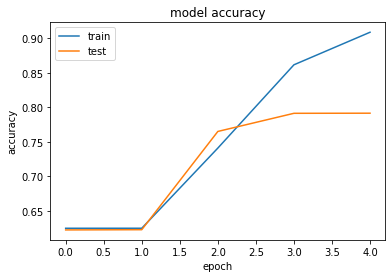

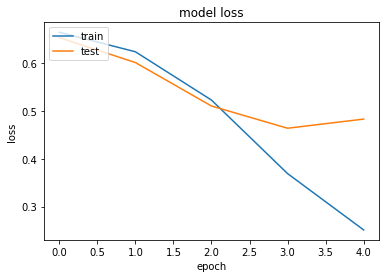

In [150]:
print('Best CNN: SHORT SENTENCES')

model = Sequential()

embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(8, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=600, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

In [129]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
hide_toggle()




LSTM
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 200, 50)           4167400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 129       
Total params: 4,259,177
Trainable params: 91,777
Non-trainable params: 4,167,400
_________________________________________________________________
None
Train on 25600 samples, validate on 6400 samples
Epoch 1/6
25600/25600 [==============================] - 99s 4ms/step - loss: 0.6634 - acc: 0.6234 - val_loss: 0.6630 - val_acc: 0.6227
Epoch 2/6
25600/25600 [==============================] - 99s 4ms/step - loss: 0.6621 - acc: 0.6250 - val_loss: 0.6629 - val_acc: 0.6227
Epoch 3/6
25600/25600 [==============

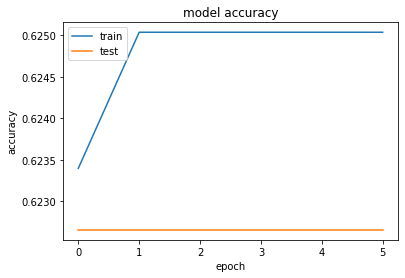

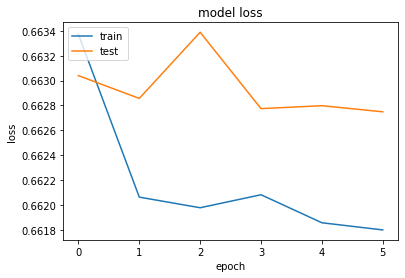

In [130]:
print('LSTM')

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

 <a id='section6.2.2'></a>
### 6.2.2 Amount of training data

In [151]:

tokenizer = Tokenizer(num_words=90000)
tokenizer.fit_on_texts(reviews[0])

train_features = tokenizer.texts_to_sequences(LittleTraining)
test_features = tokenizer.texts_to_sequences(LittleTest)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

train_features= pad_sequences(train_features, padding='post', maxlen=maxlen)
test_features = pad_sequences(test_features, padding='post', maxlen=maxlen)






Best CNN: LITTLE TRAINING
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 200, 25)           2083700   
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 198, 16)           1216      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 196, 8)            392       
_________________________________________________________________
global_max_pooling1d_47 (Glo (None, 8)                 0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 2,085,317
Trainable params: 2,085,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [=========

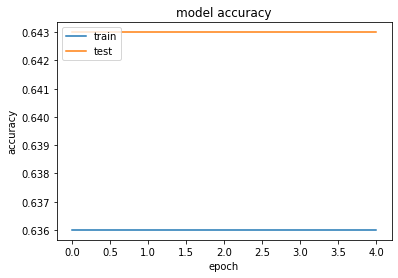

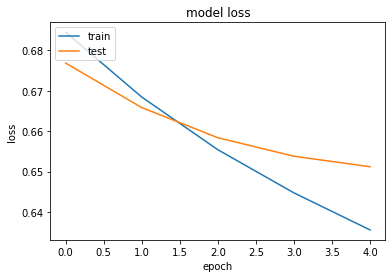

In [153]:
print('Best CNN: LITTLE TRAINING')

model = Sequential()

embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(8, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(train_features, LittleTrainingy, batch_size=600, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, LittleTesty, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

LSTM with LITTLE TRAINING
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 200, 50)           4167400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 129       
Total params: 4,259,177
Trainable params: 91,777
Non-trainable params: 4,167,400
_________________________________________________________________
None
Train on 4000 samples, validate on 1000 samples
Epoch 1/6
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6655 - acc: 0.6302 - val_loss: 0.6427 - val_acc: 0.6450
Epoch 2/6
4000/4000 [==============================] - 18s 5ms/step - loss: 0.6435 - acc: 0.6455 - val_loss: 0.6258 - val_acc: 0.6700
Epoch 3/6
4000/4000 [

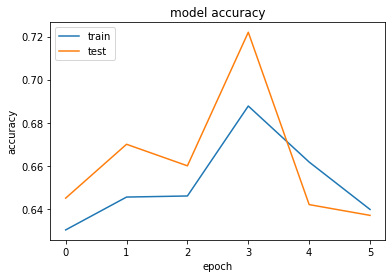

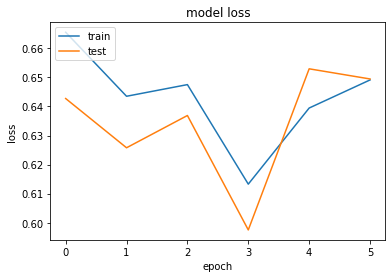

In [154]:
print('LSTM with LITTLE TRAINING')

model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


print(model.summary())
history = model.fit(train_features,  LittleTrainingy, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(test_features,  LittleTesty, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

<a id='section6.2.3'></a>
### 6.2.3 Amount of time

In [157]:

tokenizer = Tokenizer(num_words=90000)
tokenizer.fit_on_texts(reviews[0])

train_features = tokenizer.texts_to_sequences(reviews[0])
test_features = tokenizer.texts_to_sequences(test[0])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

train_features= pad_sequences(train_features, padding='post', maxlen=maxlen)
test_features = pad_sequences(test_features, padding='post', maxlen=maxlen)





Best CNN: Time Normal
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 200, 25)           2083700   
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 198, 16)           1216      
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 196, 8)            392       
_________________________________________________________________
global_max_pooling1d_50 (Glo (None, 8)                 0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 9         
Total params: 2,085,317
Trainable params: 2,085,317
Non-trainable params: 0
_________________________________________________________________
None
Train on 25600 samples, validate on 6400 samples
Epoch 1/5
25600/25600 [==========

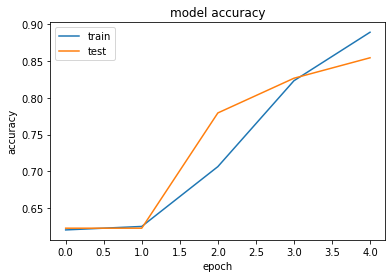

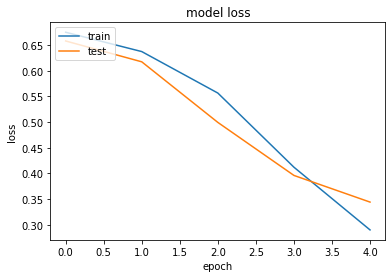

In [158]:
print('Best CNN: Time Normal')

start_time = time.time()
model = Sequential()

embedding_layer = Embedding(vocab_size, 25, input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(16, 3, activation='relu'))
model.add(Conv1D(8, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(train_features, reviews[1], batch_size=600, epochs=5, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


hide_toggle()

LSTM- normal time
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 200, 50)           4167400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 129       
Total params: 4,259,177
Trainable params: 91,777
Non-trainable params: 4,167,400
_________________________________________________________________
None
Train on 25600 samples, validate on 6400 samples
Epoch 1/6
25600/25600 [==============================] - 109s 4ms/step - loss: 0.6409 - acc: 0.6478 - val_loss: 0.6503 - val_acc: 0.6297
Epoch 2/6
25600/25600 [==============================] - 111s 4ms/step - loss: 0.6515 - acc: 0.6262 - val_loss: 0.6545 - val_acc: 0.6253
Epoch 3/6
25600/25600 

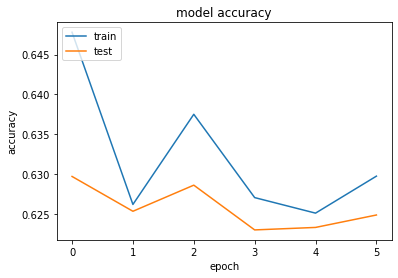

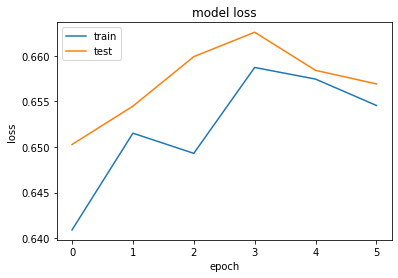

In [159]:
print('LSTM- normal time')

start_time = time.time()
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


print(model.summary())
history = model.fit(train_features,  reviews[1], batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(test_features, test[1], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

hide_toggle()

<a id='section7'></a>
# 7. Play around
Next cell to grab the NWN data

In [160]:
def grab_data(path):
    sentences = []
    currdir = os.getcwd()
    os.chdir(path)
    for ff in glob.glob("*.txt"):
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    os.chdir(currdir)
    sentences = extract_words2(sentences)

    return sentences



def main():
    # Get the dataset from http://ai.stanford.edu/~amaas/data/sentiment/
    path = dataset_path

    train_x_pos = grab_data(path+'train/pos')
    train_x_neg = grab_data(path+'train/neg')
    train_x = train_x_pos + train_x_neg
    train_y = [1] * len(train_x_pos) + [0] * len(train_x_neg)

    test_x_pos = grab_data(path+'test/pos')
    test_x_neg = grab_data(path+'test/neg')
    test_x = test_x_pos + test_x_neg
    test_y = [1] * len(test_x_pos) + [0] * len(test_x_neg)
    
    y = test_y + train_y;
    X = test_x + train_x
    X = X[0:40000]       #Irene: so that comparison with NN is fair
    y = y[0:40000]
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42)
    
    f = open('train.pkl', 'wb')
    pkl.dump((train_x, train_y), f, -1)
    f.close()
    f = open('test.pkl', 'wb')
    pkl.dump((test_x, test_y), f, -1)
    f.close()


if __name__ == '__main__':
    main()
    
f = open('train.pkl', 'rb')
reviews = pickle.load(f)
f.close()

f = open('test.pkl', 'rb')
test = pickle.load(f)
f.close()



hide_toggle()

In [ ]:
print('Play around with SVM- Normal')


# Generate counts from text using a vectorizer.  
# There are other vectorizers available, and lots of options you can set.
# This performs our step of computing word counts.
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(reviews[0])
test_features = vectorizer.transform(test[0])

# Perform classification with SVM, kernel=linear
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(train_features, reviews[1])
prediction_liblinear = classifier_liblinear.predict(test_features)
# Now we can use the model to predict classifications for our test features.
print(classification_report(test[1], prediction_liblinear))
print("accuracy: {0}".format(accuracy_score(test[1], prediction_liblinear)))


while True:
    sentences = []
    sentence = input("\n\033[93mPlease enter a sentence to get sentiment evaluated. Enter \"exit\" to quit.\033[0m\n")
    if sentence == "exit":
        print("\033[93mexit program ...\033[0m\n")
        break
    else:
        sentences.append(sentence)
        input_features = vectorizer.transform(extract_words2(sentences))
        prediction = classifier_liblinear.predict(input_features)
        if prediction[0] == 1 :
            print("---- \033[92mpositive\033[0m\n")
        else:
            print("---- \033[91mnegative\033[0m\n")
hide_toggle()

Play around with SVM- Normal
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2986
           1       0.91      0.94      0.93      5014

    accuracy                           0.90      8000
   macro avg       0.90      0.89      0.90      8000
weighted avg       0.90      0.90      0.90      8000

accuracy: 0.904875

Please enter a sentence to get sentiment evaluated. Enter "exit" to quit.
good
---- positive


Please enter a sentence to get sentiment evaluated. Enter "exit" to quit.
bad
---- negative


Please enter a sentence to get sentiment evaluated. Enter "exit" to quit.
Thank you for your attention
---- positive

